We will use the ADSim detector to show an error with the way images that have more than one dimension are handled


In [114]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [168]:
# create the SimDetector Device with a TIFF filesave mixin

# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

class SimDetectorCamV33(SimDetectorCam):
    '''This is used to update the SimDetectorCam to AD33.'''

    wait_for_plugins = Cpt(EpicsSignal, 'WaitForPlugins',
                           string=True, kind='config')

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs['wait_for_plugins'] = 'Yes'

    def ensure_nonblocking(self):
        self.stage_sigs['wait_for_plugins'] = 'Yes'
        for c in self.parent.component_names:
            cpt = getattr(self.parent, c)
            if cpt is self:
                continue
            if hasattr(cpt, 'ensure_nonblocking'):
                cpt.ensure_nonblocking()
    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCamV33, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')

def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.cam.ensure_nonblocking()



In [169]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')


In [170]:
my_sim_cam.wait_for_connection()

In [171]:
set_detector(my_sim_cam)

#initiall configure as mono to show everything works
my_sim_cam.cam.color_mode.put('Mono')


In [172]:
import databroker.core
handler_registry = databroker.core.discover_handlers()
# make sure that the python package area-detector-handlers is installed!

In [173]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 3     Time: 2021-08-05 16:07:25
Persistent Unique Scan ID: '456209ae-13f3-47f7-96d8-6414a702ffa8'
New stream: 'primary'
+-----------+------------+-----------------------+------------------+------------------------+
|   seq_num |       time | test_tiff_ndimensions | test_stats_total | test_image_ndimensions |
+-----------+------------+-----------------------+------------------+------------------------+
|         1 | 16:07:25.4 |                     2 |         14629137 |                      2 |
+-----------+------------+-----------------------+------------------+------------------------+
generator count ['456209ae'] (scan num: 3)





('456209ae-13f3-47f7-96d8-6414a702ffa8',)

In [174]:
run = db[-1]
run.primary.metadata['descriptors'][0]['data_keys']['test_image']['shape']

[1, 1024, 1024]

(1024, 1024)

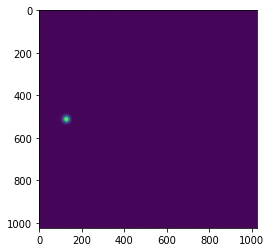

In [175]:
import glob
import os

list_of_files = glob.glob('/home/emil/Apps/autosave/images/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(latest_file, 'r')
imshow(np.asarray(pil_im))

import numpy as np
imarray = np.array(pil_im)
imarray.shape

In [176]:
image = run.primary.read()["test_image"]


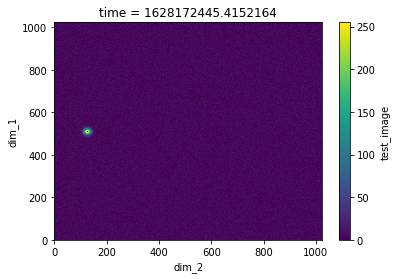

In [177]:

frame =image[0][0]
frame.plot.pcolormesh()
db_imarray = np.array(frame)

In [178]:
if db_imarray.all() == imarray.all():
    print('They are the same')

They are the same


In [179]:
#Now repeat it but setting colour mode to RGB1

#initiall configure as mono to show everything works
my_sim_cam.cam.color_mode.put('RGB1') #0 is mono, 1 is RGB1

In [180]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 4     Time: 2021-08-05 16:07:29
Persistent Unique Scan ID: '31046894-7498-457d-ac0c-af3883be93d6'
New stream: 'primary'
+-----------+------------+-----------------------+------------------+------------------------+
|   seq_num |       time | test_tiff_ndimensions | test_stats_total | test_image_ndimensions |
+-----------+------------+-----------------------+------------------+------------------------+
|         1 | 16:07:29.8 |                     3 |          4884031 |                      2 |
+-----------+------------+-----------------------+------------------+------------------------+
generator count ['31046894'] (scan num: 4)





('31046894-7498-457d-ac0c-af3883be93d6',)

(1024, 1024, 3)

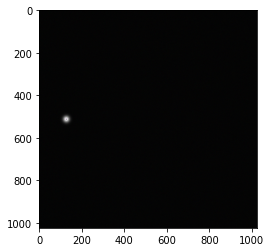

In [181]:
import glob
import os

list_of_files = glob.glob('/home/emil/Apps/autosave/images/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(latest_file, 'r')
imshow(np.asarray(pil_im))

import numpy as np
imarray = np.array(pil_im)
imarray.shape

In [182]:
run = db[-1]
run.primary.metadata['descriptors'][0]['data_keys']['test_image']['shape']

[1, 1024, 1024]

In [183]:
#This is wrong, it should be 3, which is why we get the following error when we try to read

In [184]:
image = run.primary.read()

ValueError: replacement data must match the Variable's shape. replacement data has shape (1, 1, 1024, 1024, 3); Variable has shape (1, 1, 1024, 1024)

In [156]:
# The dimension of the image is wrong in the metadata. Whenever this parameter is created, it's being done wrong. 

In [158]:
my_sim_cam.image.ndimensions.get() # This is correct

3

In [159]:
my_sim_cam.tiff.ndimensions.get() # So is this

3